## Importing Dependencies

In [1]:
# Python Standard Libraries for importing data from binary file
import os.path #for accessing the file path
import struct  #for unpacking the binary data

import time    #for calculating time
import math    #for using floor in creating minibatches


#core packages
import numpy as np
import matplotlib.pyplot as plt

#custom module
from dataPrep import load_dataset
from dataPrep import visual_charts, visualize_dataset
from dataPrep import prep_dataset

from finalModelUtils import relu, relu_grad, softmax

np.random.seed(1)
%matplotlib inline

## Dataset Preparation

### Loading Dataset

In [2]:
#loading complete dataset
train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig = load_dataset()

print("Data\t\t\t","Datatype\t\t","Shape")
print("=================================================================")
print("Training Set Images:\t" + str(type(train_x_orig))+"\t",str(train_x_orig.shape))
print("Training Set Labels:\t" + str(type(train_y_orig))+"\t",str(train_y_orig.shape))
print("Dev Set Images:\t\t" + str(type(dev_x_orig))+"\t",str(dev_x_orig.shape))
print("Dev Set Labels:\t\t" + str(type(dev_y_orig))+"\t",str(dev_y_orig.shape))
print("Test Set Images:\t" + str(type(test_x_orig))+"\t",str(test_x_orig.shape))
print("Test Set Labels:\t" + str(type(test_y_orig))+"\t",str(test_y_orig.shape))
print("=================================================================")


Data			 Datatype		 Shape
Training Set Images:	<class 'numpy.ndarray'>	 (60000, 28, 28)
Training Set Labels:	<class 'numpy.ndarray'>	 (60000, 1)
Dev Set Images:		<class 'numpy.ndarray'>	 (5000, 28, 28)
Dev Set Labels:		<class 'numpy.ndarray'>	 (5000, 1)
Test Set Images:	<class 'numpy.ndarray'>	 (5000, 28, 28)
Test Set Labels:	<class 'numpy.ndarray'>	 (5000, 1)


### Preparing Dataset

In [3]:
# Preparing the Dataset (Flattening and Normalizing)
train_x_norm,train_y_encoded, dev_x_norm,dev_y_encoded, test_x_norm, test_y_encoded = prep_dataset(train_x_orig, train_y_orig, dev_x_orig,dev_y_orig,test_x_orig,test_y_orig)

print("Data\t\t\t","Before Processing\t","After Processing")
print("=================================================================")
print("Training Set Images:\t" + str(train_x_orig.shape)+"\t\t"+ str(train_x_norm.shape))
print("Training Set Labels:\t" + str(train_y_orig.shape)+"\t\t"+ str(train_y_encoded.shape))
print("Dev Set Images:\t\t" + str(dev_x_orig.shape)+"\t\t"+ str(dev_x_norm.shape))
print("Dev Set Labels:\t\t" + str(dev_y_orig.shape)+"\t\t"+ str(dev_y_encoded.shape))
print("Test Set Images:\t" + str(test_x_orig.shape)+"\t\t"+ str(test_x_norm.shape))
print("Test Set Labels:\t" + str(test_y_orig.shape)+"\t\t"+ str(test_y_encoded.shape))
print("=================================================================")

Data			 Before Processing	 After Processing
Training Set Images:	(60000, 28, 28)		(784, 60000)
Training Set Labels:	(60000, 1)		(10, 60000)
Dev Set Images:		(5000, 28, 28)		(784, 5000)
Dev Set Labels:		(5000, 1)		(10, 5000)
Test Set Images:	(5000, 28, 28)		(784, 5000)
Test Set Labels:	(5000, 1)		(10, 5000)


### Visualizing Dataset

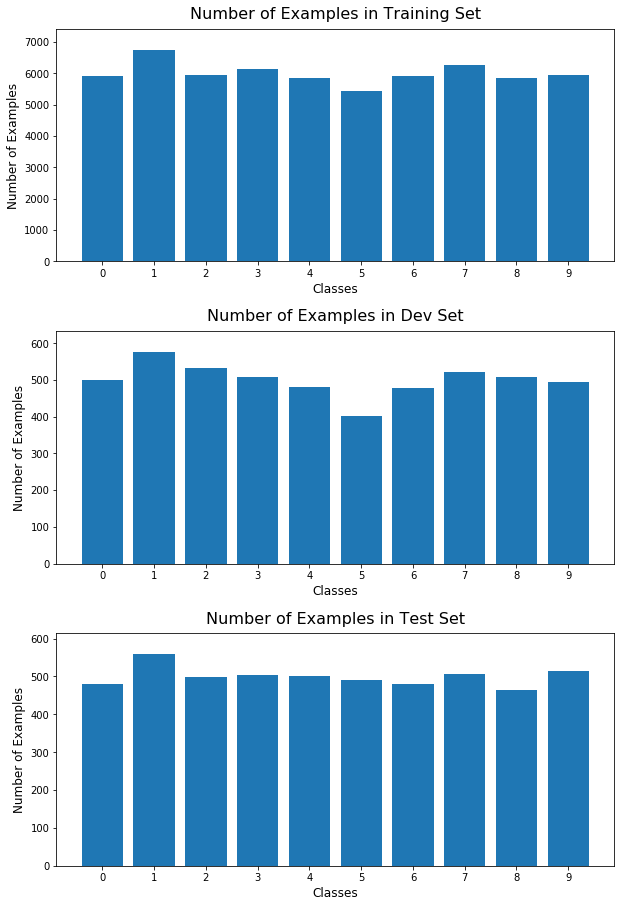

In [4]:
# charts showing number of examples in each class
visual_charts(train_y_orig, dev_y_orig, test_y_orig)

### Creating Minibatches

In [5]:
def rand_mini_batches(X, Y, mini_batch_size = 64, seed=1):
   
    classes = Y.shape[0]
    np.random.seed(seed)            
    m = X.shape[1]                  # number of training examples
    mini_batches = []
        
#     Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((classes,m))

#     Partition (shuffled_X, shuffled_Y) except for the last batch
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size 
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : (k+1)*mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : (k+1)*mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Last batch (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

## Model Implementation

### Initializing the Model

#### Initializing Layers

In [6]:
def init_layers(X,Y,hidden_layers):
    
    input_nodes = X.shape[0]
    output_nodes = Y.shape[0]
    
    layers_dim = [input_nodes]
    
    for i in hidden_layers:
        layers_dim.append(i)
    
    layers_dim.append(output_nodes)
    
    return layers_dim

In [7]:
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [32,16])
print(layers_dim)

[784, 32, 16, 10]


#### Initializing Parameters

In [8]:
def init_parameters(layers_dim, initialization = "random"):
    
    L = len(layers_dim)
    params = {}
        
    for l in range(1,L):
        #initializing Weights
        if initialization == "he":
            # he-initialization
            params['W' + str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) * np.sqrt(np.divide(2,layers_dim[l-1])) 
        elif initialization == "random":
            # random initialization scaled by 0.01
            params['W' + str(l)] = np.random.randn(layers_dim[l],layers_dim[l-1]) * 0.01 
        else:
             raise ValueError("Initialization must be 'random' or 'he'")
        
        #initializing biases
        params['b' + str(l)] = np.zeros((layers_dim[l],1))
     
        assert(params['W' + str(l)].shape == (layers_dim[l],layers_dim[l-1])), "Dimention of W mismatched in init_params function"
        assert(params['b' + str(l)].shape == (layers_dim[l],1)), "Dimention of b mismatched in init_params function"
   
    return params

In [9]:
parameters = init_parameters(layers_dim, initialization = "random")
print("Layer\tWeight\t\tBias")
print("================================")
for l in range(1,len(layers_dim)):
    print(str(l) +"\t" + str(parameters['W'+str(l)].shape) +"\t"+ str(parameters['b'+str(l)].shape))


Layer	Weight		Bias
1	(32, 784)	(32, 1)
2	(16, 32)	(16, 1)
3	(10, 16)	(10, 1)


#### Initializing Hyper Parameters

In [10]:
def init_hyperParams(alpha, num_epoch, mini_batch_size, lambd = 0, keep_probs = []):
    hyperParams = {}
    hyperParams['learning_rate'] = alpha
    hyperParams['num_epoch'] = num_epoch
    hyperParams['mini_batch_size'] = mini_batch_size
    hyperParams['lambda'] = lambd
    hyperParams['keep_probs'] = keep_probs
    hyperParams['beta1'] = 0.9
    hyperParams['beta2'] = 0.999
    hyperParams['epsilon'] = 1e-8
    
    
    return hyperParams

In [11]:
hyperParams = init_hyperParams(alpha = 0.0001, num_epoch = 10, mini_batch_size = 1024,lambd = 0.7,keep_probs = [0.8,0.8])
for key,value in hyperParams.items():
    print(key + ": " + str(value))

learning_rate: 0.0001
num_epoch: 10
mini_batch_size: 1024
lambda: 0.7
keep_probs: [0.8, 0.8]
beta1: 0.9
beta2: 0.999
epsilon: 1e-08


### Forward Propagation

#### Forward Sum for individual Layer

In [12]:
def forward_sum(A_prev,W,b):
    
    m = A_prev.shape[1]
    
    Z = np.dot(W,A_prev) + b
    
    cache = (A_prev,W,b)
    
    assert (Z.shape == (W.shape[0], m)), "Dimention of Z mismatched in forward_prop function"
    
    return Z, cache

#### Forward Activation for individual Layer

In [13]:
def forward_activation(A_prev,W,b,activation):
    
    if activation == 'relu':
        Z, sum_cache = forward_sum(A_prev,W,b)
        A, activation_cache = relu(Z)
        
    if activation == 'softmax':
        Z, sum_cache = forward_sum(A_prev,W,b)
        A, activation_cache = softmax(Z)
    
    cache = (sum_cache,activation_cache)
    
    assert(A.shape == Z.shape), "Dimention of A mismatched in forward_activation function"
    
    return A, cache

#### Dropout for individual Layer

In [14]:
def forward_dropout(A,keep_probs):
     #implementing dropout
    D = np.random.rand(A.shape[0],A.shape[1])
    D = (D < keep_probs).astype(int)
    A = np.multiply(A,D)
    A = np.divide(A,keep_probs)
    
    dropout_mask = D
    
    assert (dropout_mask.shape == A.shape), "Dimention of dropout_mask mismatched in forward_dropout function"
    return A,dropout_mask

#### Forward Prop for L Layers

In [15]:
def forward_prop(X, parameters, keep_probs = [], regularizer = None):
    caches = []
    A = X
    L = len(parameters) // 2
    
    dropout_masks = []

    # len(keep_probs) == L-1: no dropouts in the Output layer, no dropout at all for prediction
    if regularizer == "dropout":
        assert(len(keep_probs) == L-1 ) 
    
    for l in range(1, L):
        A_prev = A 
        A, cache = forward_activation(A_prev,parameters['W' + str(l)],parameters['b' + str(l)], activation='relu')
        caches.append(cache)
        if regularizer == "dropout":
            A , dropout_mask = forward_dropout(A,keep_probs[l-1])
            dropout_masks.append(dropout_mask)
        else:
            pass

    AL, cache = forward_activation(A,parameters['W' + str(L)],parameters['b' + str(L)], activation='softmax')
    caches.append(cache)
    
    assert(AL.shape == (10,X.shape[1])), "Dimention of AL mismatched in forward_prop function"
    
    return AL,caches,dropout_masks
    

In [16]:
a = forward_prop(train_x_norm, parameters, keep_probs = [], regularizer = "no")

### Compute Cost

In [17]:
def softmax_cross_entropy_cost(AL, Y, caches, lambd = 0, regularizer = None):
    L = len(caches)
    m = Y.shape[1]
    
    cost = -(1./m) * np.sum(np.sum(np.multiply(Y,np.log(AL)), axis = 0,keepdims=True))
    
    if regularizer == "l2":
        norm = 0
        for l in range(L):
            current_cache = caches[l]
            sum_cache, _ = current_cache
            _,W,_ = sum_cache
            norm += np.sum(np.square(W))

        L2_cost = (lambd/(2*m)) * norm 
        cost = cost + L2_cost
    else:
        pass
    
    cost = np.squeeze(cost)      # Making sure your cost's shape is not returned as ndarray
    
    assert(cost.shape == ()),"Dimention of cost mismatched in softmax_cross_entropy_cost function"
    
    return cost

### Backward Propagation

#### Calculating Gradients for individual Layer

In [18]:
def backward_grad(dZ, cache, lambd, regularizer):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    if regularizer == "l2":
        dW = (1/m) * np.dot(dZ,A_prev.T) + np.multiply(np.divide(lambd,m),W )
    else:
        dW = (1/m) * np.dot(dZ,A_prev.T)

    db = (1/m) * np.sum(dZ, axis = 1, keepdims=True )
    dA_prev = np.dot(W.T, dZ)

    
    assert (dW.shape == W.shape), "Dimention of dW mismatched in backward_grad function"
    assert (db.shape == b.shape), "Dimention of db mismatched in backward_grad function"
    assert (dA_prev.shape == A_prev.shape), "Dimention of dA_prev mismatched in backward_grad function"
    
    
    return dA_prev, dW, db

#### Calculating Backward Activation for individual layer

In [19]:
def backward_activation(dA, cache, lambd ,regularizer, activation):
    sum_cache, activation_cache = cache
    
    if activation == "relu":
        dZ = relu_grad(dA,activation_cache)
        dA_prev, dW, db = backward_grad(dZ, sum_cache, lambd, regularizer = regularizer)
        
    elif activation == "softmax":
        dZ = dA
        dA_prev, dW, db = backward_grad(dA, sum_cache, lambd, regularizer = regularizer)
    
    return dA_prev, dW, db
    
    

#### Complete Backward Propagation for L layers

In [20]:
def backward_dropout(dA_prev_temp, D, keep_prob):
    dA_prev = np.multiply(dA_prev_temp,D)
    dA_prev = np.divide(dA_prev,keep_prob)
    return dA_prev

In [21]:
def backward_prop(AL, Y, caches, dropout_masks = [], keep_probs = [], lambd = 0, regularizer = None):
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    dA = np.subtract(AL,Y)
    
    current_cache = caches[L-1]
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = backward_activation(dA, current_cache,lambd = lambd, regularizer = regularizer, activation = 'softmax')
    
    for l in reversed(range(L-1)):
        current_cache = caches[l]
        
        if regularizer == "dropout":
            #implementing dropout
            D = dropout_masks[l]
            dA_prev_temp = backward_dropout(grads["dA" + str(l + 1)], D, keep_probs[l])
            dA_prev, dW_temp, db_temp = backward_activation(dA_prev_temp, current_cache, lambd = lambd, regularizer = regularizer, activation = 'relu')
        else:
            dA_prev, dW_temp, db_temp = backward_activation(grads["dA" + str(l + 1)], current_cache, lambd = lambd, regularizer = regularizer, activation = 'relu')
            
        
        grads["dA" + str(l)] = dA_prev
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp

    return grads

### Update Parameters

In [22]:
#initialize adam

def initialize_adam(parameters) :
   
    L = len(parameters) // 2 
    v = {}
    s = {}
    
    for l in range(L):
        v["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        v["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
        s["dW" + str(l+1)] = np.zeros(parameters["W" + str(l+1)].shape)
        s["db" + str(l+1)] = np.zeros(parameters["b" + str(l+1)].shape)
    
    return v, s

In [23]:
def update_parameters(parameters, grads, learning_rate, optimizer = "bgd", beta1 = 0, beta2 = 0,  epsilon = 0, v = {}, s = {}, t = 0):
       
    L = len(parameters) // 2           
    v_corrected = {}                         
    s_corrected = {}                       
    
    for l in range(L):
        if optimizer == 'adam':
            # Moving average of the gradients.
            v["dW" + str(l+1)] = np.add(beta1 * v["dW" + str(l+1)], (1 - beta1) * grads["dW" + str(l+1)])
            v["db" + str(l+1)] = np.add(beta1 * v["db" + str(l+1)], (1 - beta1) * grads["db" + str(l+1)])

            # Compute bias-corrected first moment estimate.
            v_corrected["dW" + str(l+1)] = np.divide(v["dW" + str(l+1)], (1 - np.power(beta1,t)))
            v_corrected["db" + str(l+1)] = np.divide(v["db" + str(l+1)], (1 - np.power(beta1,t)))

            # Moving average of the squared gradients. 
            s["dW" + str(l+1)] = np.add(beta2 * s["dW" + str(l+1)], (1 - beta2) * np.square(grads["dW" + str(l+1)]))
            s["db" + str(l+1)] = np.add(beta2 * s["db" + str(l+1)], (1 - beta2) * np.square(grads["db" + str(l+1)]))

            # Compute bias-corrected second raw moment estimate. 
            s_corrected["dW" + str(l+1)] = np.divide(s["dW" + str(l+1)], (1 - np.power(beta2,t)))
            s_corrected["db" + str(l+1)] = np.divide(s["db" + str(l+1)], (1 - np.power(beta2,t)))

            # Update parameters. 
            parameters["W" + str(l+1)] = np.subtract(parameters["W" + str(l+1)],  learning_rate * np.divide(v_corrected["dW" + str(l+1)], np.sqrt(s_corrected["dW" + str(l+1)]) + epsilon))
            parameters["b" + str(l+1)] = np.subtract(parameters["b" + str(l+1)],  learning_rate * np.divide(v_corrected["db" + str(l+1)], np.sqrt(s_corrected["db" + str(l+1)]) + epsilon))
        else:
            parameters["W" + str(l+1)] = parameters["W" + str(l+1)] - (learning_rate * grads["dW" + str(l+1)])
            parameters["b" + str(l+1)] = parameters["b" + str(l+1)] - (learning_rate * grads["db" + str(l+1)])
            
    return parameters, v, s

### Prediction

In [286]:
def predict(X,y,parameters):
    m = y.shape[1]
    n = len(parameters) // 2 # number of layers in the neural network
    
    # no keep_probs : no dropout during prediction 
    probas, caches, _ = forward_prop(X, parameters)
    loss = softmax_cross_entropy_cost(probas, y, caches) 
    
    assert(probas.shape == y.shape)
        
    true_labels = np.argmax(y,axis=0).reshape(1,m)
    
    predicted_labels = np.argmax(probas,axis=0).reshape(1,m)
    predicted_prob = np.max(probas,axis = 0).reshape(1,m)
    
    second_max = np.array(probas, copy=True)
    second_max[predicted_labels,np.arange(predicted_labels.size)] = 0 #zeroing out the first max prediction
    sec_predicted_labels = np.argmax(second_max,axis=0).reshape(1,m) #selecting the second max predicted label
    sec_predicted_prob = np.max(second_max,axis = 0).reshape(1,m) #selecting the second max prediction
    
    prediction = {"First Prediction":(predicted_labels, predicted_prob),
                  "Second Prediction":(sec_predicted_labels, sec_predicted_prob)      
        
    }
    
    #print results
    true_prediction = np.equal(predicted_labels,true_labels)
    
    num_correct_labels = np.sum(true_prediction)
    accuracy = (num_correct_labels/m)
        
    return prediction, accuracy, loss


In [284]:
np.random.seed(2)
a = np.random.rand(5,3)
# print(a)

m = a.shape[1] 
a_labels = np.argmax(a,axis=0).reshape(1,m)
a_prob = np.max(a,axis = 0).reshape(1,m)

print(a_labels, a_labels.reshape(1,m))

b = np.array(a, copy = True)
print(b)

# b[a_labels.T] = 0 #zeroing out the first max prediction
b[a_labels,np.arange(a_labels.size)] = 0
print(b)

b_predicted_labels = np.argmax(b,axis=0).reshape(1,m) #selecting the second max predicted label
b_predicted_prob = np.max(b,axis = 0).reshape(1,m) #selecting the second max prediction
    
print(b_predicted_labels)


[[0 3 0]] [[0 3 0]]
[[0.4359949  0.02592623 0.54966248]
 [0.43532239 0.4203678  0.33033482]
 [0.20464863 0.61927097 0.29965467]
 [0.26682728 0.62113383 0.52914209]
 [0.13457995 0.51357812 0.18443987]]
[[0.         0.02592623 0.        ]
 [0.43532239 0.4203678  0.33033482]
 [0.20464863 0.61927097 0.29965467]
 [0.26682728 0.         0.52914209]
 [0.13457995 0.51357812 0.18443987]]
[[1 2 3]]


#### Visualizing the costs and accuracy for model analysis

In [25]:
def visualize_training_results(train_accs, val_accs, train_loss, val_loss):
    
    #creating subplots
    fig, axes = plt.subplots(nrows=2, ncols = 1,figsize=(10,10))
    fig.subplots_adjust(wspace=.2, hspace = .2)
    
     
#     axes[0].plot(np.squeeze(cost), label = 'Cost', color ='green')
    axes[0].plot(np.squeeze(train_loss), label = 'Training Loss', color = 'blue')
    axes[0].plot(np.squeeze(val_loss), label = 'Validation Loss', color = 'red')
    axes[0].legend(loc='center right')
    
    axes[0].set_title("Training and Validation Loss " , fontsize = 16, pad = 10)
    axes[0].set_xlabel("No. of Epochs", fontsize = 12)
    axes[0].set_ylabel("Loss", fontsize = 12)
    
    axes[1].plot(np.squeeze(train_accs), label = 'Training Accuracy', color = 'blue')
    axes[1].plot(np.squeeze(val_accs), label = 'Validation Accuracy', color = 'red')
    axes[1].legend(loc='center right')
    axes[1].set_title("Accuracy " , fontsize = 16, pad = 10)
    axes[1].set_xlabel("No. of Epochs", fontsize = 12)
    axes[1].set_ylabel("Accuracy", fontsize = 12)
        

    plt.show()

In [26]:
def convert_time(millisec):
    
    hours = millisec // 3.6e+6
    
    mins = (millisec % 3.6e+6) // 60000
    
    secs = ((millisec % 3.6e+6) % 60000) // 1000
    
    millisec = ((millisec % 3.6e+6) % 60000) % 1000
    
    return (hours,mins,secs, millisec)

### Train Model

In [28]:
def train(X_train, Y_train, X_dev, Y_dev, layers_dim, hyperParams, initialization = "random", optimizer = 'bgd',regularizer = None ):
    # loading the hyper parameters
    learning_rate = hyperParams['learning_rate']
    num_epoch = hyperParams['num_epoch']
    b1 = hyperParams['beta1']
    b2 = hyperParams['beta2']
    ep = hyperParams['epsilon']
    lambd = hyperParams['lambda']
    keep_probs = hyperParams['keep_probs']
    
    #initializing the variables
    seed = 1
    m = Y_train.shape[1]
    costs = []      # keep track of epoch cost    
    train_accs = []  # keep track of training accuracy
    val_accs = []     # keep track of Validation accuracy
    train_losses = []  # keep track of training loss
    val_losses = []     # keep track of Validation loss
    
    #selecting the minibatch size for each optimizer
    if optimizer == 'sgd':
        mini_batch_size = 1
    elif optimizer == 'bgd':
        mini_batch_size = m
    elif optimizer == 'mgd' or optimizer == 'adam':
        mini_batch_size = hyperParams['mini_batch_size']
    else:
        raise ValueError("Optimizer value out of scope")
        
    #initializing the model parameters
    parameters = init_parameters(layers_dim, initialization)
    
    #initializing adam parameters, used only when optimizer = 'adam'
    t = 0
    v,s = initialize_adam(parameters)
    
    #Gradient Descent begins
    train_toc = time.time() # for calculating entire training time
    for i in range(0, num_epoch):
        seed += 1
        batch_cost = []
        batch_trained = 0
        batch_time = 0
        print("\nEpoch: %d/%d"%(i+1,num_epoch))
        
        minibatches = rand_mini_batches(X_train, Y_train, mini_batch_size, seed)
        
        
        for minibatch in minibatches:
            batch_toc = time.time() # for calculating time of an epoch cycle
            
            #retriving minibatch of X and Y from training set
            (minibatch_X, minibatch_Y) = minibatch
            
            #forward Propagation
            AL, caches, dropout_masks = forward_prop(minibatch_X, parameters, keep_probs = keep_probs, regularizer = regularizer)
            
            #Computing cross entropy cost
            cross_entropy_cost = softmax_cross_entropy_cost(AL, minibatch_Y, caches, lambd = lambd, regularizer = regularizer) #accumulating the batch costs
            batch_cost.append(cross_entropy_cost)   
            #Backward Propagation
            grads = backward_prop(AL, minibatch_Y, caches, dropout_masks = dropout_masks, keep_probs = keep_probs, lambd = lambd, regularizer = regularizer)
                
            #Updating parameters
            t += 1
            parameters, v, s = update_parameters(parameters, grads, learning_rate, optimizer = optimizer, beta1 = b1, beta2 = b2,  epsilon = ep, v = v, s = s, t = t)
        
            #computing and accumulating training and validation accuracy
            _,_,train_acc,train_loss = predict(X_train, Y_train, parameters)
            _,_,val_acc, val_loss= predict(X_dev, Y_dev, parameters)  
            train_accs.append(train_acc)
            val_accs.append(val_acc)
            train_losses.append(train_loss)
            val_losses.append(val_loss)
            
            batch_tic = time.time()  # for calculating epoch time
            batch_time += (batch_tic - batch_toc)
            
            batch_trained += minibatch_Y.shape[1]
            batch_trained_per = (batch_trained / m) * 100
            inc = (int(batch_trained_per)//10)
            print ("%d/%d [%s>%s %.0f%%] - %.2fs | loss: %.4f | acc: %.4f | Val loss: %.4f | Val acc: %.4f "%(batch_trained, m, '=' * inc,'.'*(10-inc), batch_trained_per, batch_time, train_loss, train_acc, val_loss, val_acc),end='\r')
            
        epoch_cost = np.mean(batch_cost)
        costs.append(epoch_cost)
    
    train_tic = time.time() # for calculating entire training time
    hrs, mins, secs , ms = convert_time((train_tic - train_toc)*1000)
    print("\nTotal Training Time = %dhr %dmins %dsecs %.2fms"%(hrs, mins, secs, ms))
    
    #visualizing the result of the training
    visualize_training_results(train_accs, val_accs, train_losses, val_losses)    
    
    return parameters

#### Running Model


Epoch: 1/30
60000/60000 [==========> 100%] - 187.20s | loss: 0.3772 | acc: 0.9002 | Val loss: 0.3588 | Val acc: 0.9090 
Epoch: 2/30
60000/60000 [==========> 100%] - 191.09s | loss: 0.2557 | acc: 0.9282 | Val loss: 0.2473 | Val acc: 0.9314 
Epoch: 3/30
60000/60000 [==========> 100%] - 192.71s | loss: 0.2065 | acc: 0.9422 | Val loss: 0.2052 | Val acc: 0.9430 
Epoch: 4/30
60000/60000 [==========> 100%] - 194.20s | loss: 0.1748 | acc: 0.9502 | Val loss: 0.1762 | Val acc: 0.9522 
Epoch: 5/30
60000/60000 [==========> 100%] - 196.54s | loss: 0.1510 | acc: 0.9571 | Val loss: 0.1574 | Val acc: 0.9550 
Epoch: 6/30
60000/60000 [==========> 100%] - 195.47s | loss: 0.1336 | acc: 0.9622 | Val loss: 0.1416 | Val acc: 0.9596 
Epoch: 7/30
60000/60000 [==========> 100%] - 196.80s | loss: 0.1196 | acc: 0.9664 | Val loss: 0.1311 | Val acc: 0.9620 
Epoch: 8/30
60000/60000 [==========> 100%] - 198.44s | loss: 0.1074 | acc: 0.9698 | Val loss: 0.1200 | Val acc: 0.9640 
Epoch: 9/30
60000/60000 [==========> 10

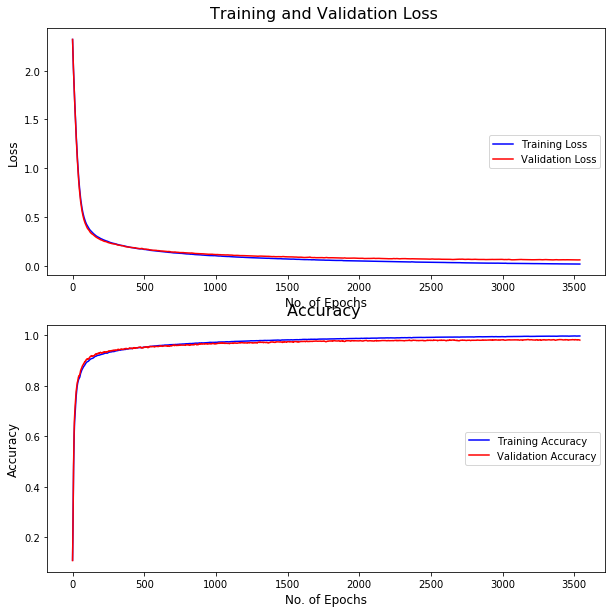

In [29]:
layers_dim = init_layers(train_x_norm, train_y_encoded, hidden_layers = [800,300])
hyperParams = init_hyperParams(alpha = 0.0001, num_epoch = 30, mini_batch_size = 512,lambd = 0.7,keep_probs = [0.9,.8,])
parameters = train(train_x_norm, train_y_encoded,dev_x_norm, dev_y_encoded,layers_dim, hyperParams, initialization = "he", optimizer = 'adam',regularizer = 'dropout')

In [287]:
prediction_train,train_acc,_ = predict(train_x_norm, train_y_encoded,parameters)
print("\nAccuracy: "  + str(train_acc))
print("\nError:\t"+str(1-train_acc))


Accuracy: 0.9958

Error:	0.0041999999999999815


In [288]:
prediction_dev,dev_acc, _ = predict(dev_x_norm, dev_y_encoded,parameters)
print("\nAccuracy: "  + str(dev_acc))
print("\nError:\t"+str(1-dev_acc))


Accuracy: 0.9794

Error:	0.02059999999999995


In [289]:
prediction_test,test_acc,_ = predict(test_x_norm, test_y_encoded,parameters)
print("\nAccuracy: "  + str(test_acc))
print("\nError:\t"+str(1-test_acc))


Accuracy: 0.981

Error:	0.019000000000000017


### Confusion Matrix

In [308]:
def confusion_matrix(y_orig,prediction):
    first_predict = prediction["First Prediction"]

    y_predicted = first_predict[0]
    y_predicted = y_predicted.T
    
    m = y_orig.shape[0]
    k = len(np.unique(y_orig)) # or simply take k =10
    
    cm = np.zeros((k,k))

    for i in range(m):
        cm[y_orig[i],y_predicted[i]] += 1
   
    return cm.astype(int)

In [307]:
cm_train = confusion_matrix(train_y_orig,prediction_train)
print("\nConfusion Matrix for Training set:\n")
print(cm_train)

cm_dev = confusion_matrix(dev_y_orig,prediction_dev)
print("\nConfusion Matrix for Dev set:\n")
print(cm_dev)

cm_test = confusion_matrix(test_y_orig,prediction_test)
print("\nConfusion Matrix for Test set:\n")
print(cm_test)


Confusion Matrix for Training set:

[[5913    0    3    0    0    0    2    0    3    2]
 [   0 6710    9    1    5    0    1    9    5    2]
 [   3    2 5939    0    4    0    0    5    3    2]
 [   0    0    8 6099    0    8    0    4    6    6]
 [   0    3    1    0 5831    0    1    1    0    5]
 [   1    1    1    4    0 5400    6    0    6    2]
 [   5    3    1    0    5    3 5899    0    2    0]
 [   1    9   10    0    7    0    0 6229    1    8]
 [   4   11    5    2    2    2    2    2 5816    5]
 [   4    2    0    2   11    3    1   10    4 5912]]

Confusion Matrix for Dev set:

[[494   0   0   0   1   1   0   1   1   1]
 [  0 570   2   1   0   0   1   0   2   0]
 [  3   1 517   2   1   0   1   3   5   0]
 [  0   0   2 500   0   1   0   2   1   1]
 [  1   0   1   0 475   0   1   0   1   3]
 [  0   0   0   3   1 393   1   1   0   2]
 [  3   0   0   0   2   3 469   0   0   0]
 [  2   1   6   1   1   0   0 504   3   4]
 [  1   0   1   1   3   2   2   2 494   3]
 [  1   0   0

In [109]:
def plot_confusion_matrix(cm):
    fig, ax = plt.subplots(figsize=(10,10))
    im = plt.imshow(cm,cmap="GnBu") #RdYlGn, PiYG, Accent,Blues,viridis, YlGnBu


    fig.colorbar(im,ax=ax,fraction=0.045)
    # ax.set_aspect('auto')

    ax.set_title("Confusion Matrix",fontsize=24,pad = 20)
    ax.set_xticks(range(0,10))
    ax.set_yticks(range(0,10))
    ax.set_xlabel("Predicted", fontsize = 20)
    ax.set_ylabel("Expexted", fontsize = 20)

    ax.set_xticklabels([0,1,2,3,4,5,6,7,8,9],fontsize=16)
    ax.set_yticklabels([0,1,2,3,4,5,6,7,8,9],fontsize=16)

    #setting horizontal axes labeling to top.
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')


    # Turn off all the ticks
    ax.tick_params(top=False,left=False)


    thres = cm.max()//2

    for i in range(10):
        for j in range(10):
            per = cm[i,j]/cm.sum() * 100
            text = ax.text(j, i, "%d\n%.2f%%"%(cm[i, j], per),
                           ha="center", va="center", color="w" if cm[i,j] > thres else "black")


    fig.tight_layout()
    plt.show()


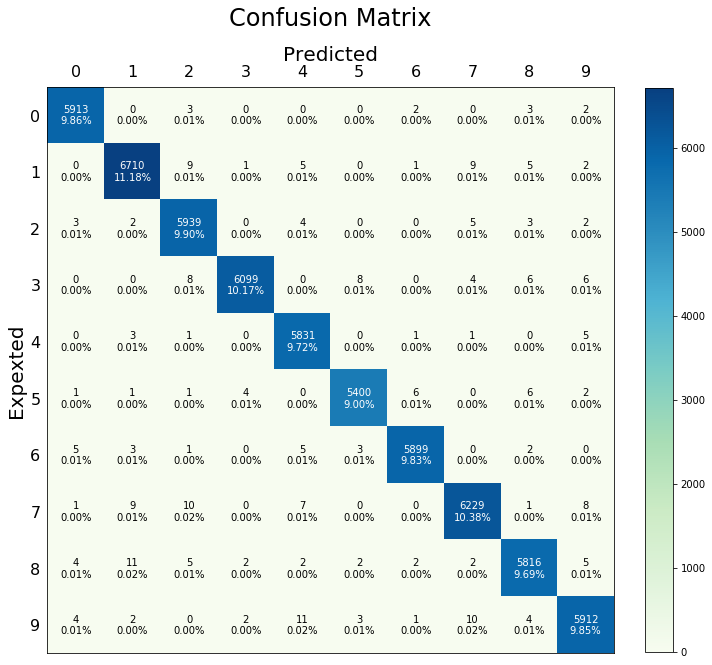

In [110]:
#plotting the confusion matrix   
plot_confusion_matrix(cm_train)

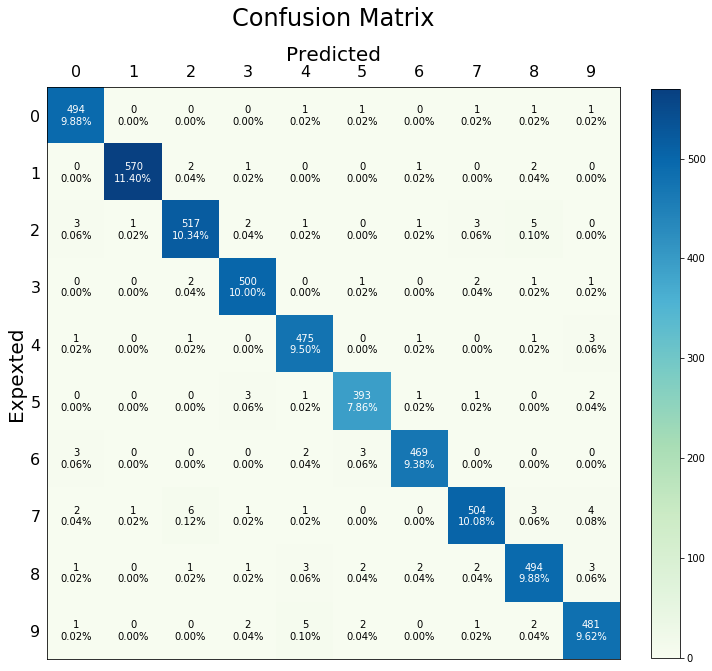

In [111]:
plot_confusion_matrix(cm_dev)

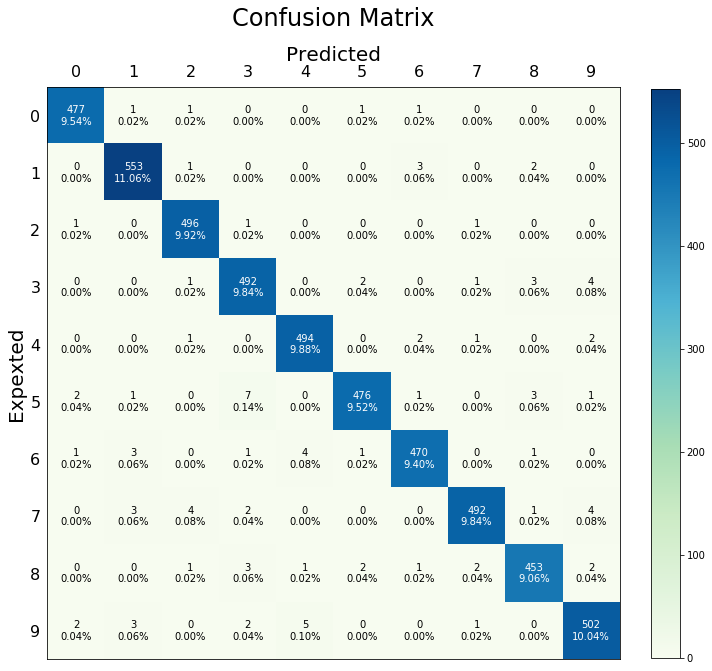

In [112]:
plot_confusion_matrix(cm_test)

In [279]:
def precision(label, cm):
    col = cm[:, label]
    prec = cm[label, label] / col.sum()
    return prec
    
def recall(label, cm):
    row = cm[label, :]
    rec = cm[label, label] / row.sum()
    return rec

def precision_average(prec):
    count = len(prec)    
    prec_mac_avg = np.sum(prec) / count
    return prec_mac_avg

def recall_average(rec):
    count = len(rec)
    rec_mac_avg = np.sum(rec) / count
    return rec_mac_avg

def accuracy(cm):
    diagonal_sum = cm.trace()
    sum_of_all_elements = cm.sum()
    acc = diagonal_sum / sum_of_all_elements 
    return acc

def f1_score(prec,rec):
    f1 = (2 * prec * rec) / (prec + rec)
    return f1

def summary(cm):
    print("+=======+===============+===============+===============+")
    print("| Label\t| Precision \t| Recall \t| F1 Score \t|")
    print("+=======+===============+===============+===============+")
    prec = []
    rec = []
    f1 = []
    for label in range(10):
        prec.append(precision(label, cm))
        rec.append(recall(label, cm))
        f1.append(f1_score(prec[label], rec[label]))
        print("| %d \t|  %.5f \t|  %.5f \t|  %.5f \t|"%(label, prec[label], rec[label], f1[label]))


    print("+=======+===============+===============+===============+") 
    
    
    avg_precision = precision_average(prec)
    avg_recall = recall_average(rec)
    acc = accuracy(cm)
    avg_f1 = f1_score(avg_precision,avg_recall)
    
    print("| Avg \t|  %.5f \t|  %.5f \t|  %.5f \t|"%( avg_precision, avg_recall, avg_f1))
    print("+=======+===============+===============+===============+") 
    
    print("\n Accuracy \t\t  %.5f"%( acc))
    

In [280]:
summary(cm_train)

+=======+===============+===============+===============+
| Label	| Precision 	| Recall 	| F1 Score 	|
+=======+===============+===============+===============+
| 0 	|  0.99697 	|  0.99831 	|  0.99764 	|
| 1 	|  0.99540 	|  0.99525 	|  0.99533 	|
| 2 	|  0.99364 	|  0.99681 	|  0.99522 	|
| 3 	|  0.99853 	|  0.99478 	|  0.99665 	|
| 4 	|  0.99420 	|  0.99812 	|  0.99616 	|
| 5 	|  0.99705 	|  0.99613 	|  0.99659 	|
| 6 	|  0.99780 	|  0.99679 	|  0.99730 	|
| 7 	|  0.99505 	|  0.99425 	|  0.99465 	|
| 8 	|  0.99487 	|  0.99402 	|  0.99444 	|
| 9 	|  0.99462 	|  0.99378 	|  0.99420 	|
+=======+===============+===============+===============+
| Avg 	|  0.99581 	|  0.99582 	|  0.99582 	|
+=======+===============+===============+===============+

 Accuracy 		  0.99580


In [281]:
summary(cm_dev)

+=======+===============+===============+===============+
| Label	| Precision 	| Recall 	| F1 Score 	|
+=======+===============+===============+===============+
| 0 	|  0.97822 	|  0.98998 	|  0.98406 	|
| 1 	|  0.99650 	|  0.98958 	|  0.99303 	|
| 2 	|  0.97732 	|  0.96998 	|  0.97363 	|
| 3 	|  0.98039 	|  0.98619 	|  0.98328 	|
| 4 	|  0.97137 	|  0.98548 	|  0.97837 	|
| 5 	|  0.97761 	|  0.98005 	|  0.97883 	|
| 6 	|  0.98737 	|  0.98323 	|  0.98529 	|
| 7 	|  0.98054 	|  0.96552 	|  0.97297 	|
| 8 	|  0.97053 	|  0.97053 	|  0.97053 	|
| 9 	|  0.97172 	|  0.97368 	|  0.97270 	|
+=======+===============+===============+===============+
| Avg 	|  0.97916 	|  0.97942 	|  0.97929 	|
+=======+===============+===============+===============+

 Accuracy 		  0.97940


In [282]:
summary(cm_test)

+=======+===============+===============+===============+
| Label	| Precision 	| Recall 	| F1 Score 	|
+=======+===============+===============+===============+
| 0 	|  0.98758 	|  0.99168 	|  0.98963 	|
| 1 	|  0.98050 	|  0.98927 	|  0.98486 	|
| 2 	|  0.98218 	|  0.99399 	|  0.98805 	|
| 3 	|  0.96850 	|  0.97813 	|  0.97329 	|
| 4 	|  0.98016 	|  0.98800 	|  0.98406 	|
| 5 	|  0.98755 	|  0.96945 	|  0.97842 	|
| 6 	|  0.98326 	|  0.97713 	|  0.98019 	|
| 7 	|  0.98795 	|  0.97233 	|  0.98008 	|
| 8 	|  0.97840 	|  0.97419 	|  0.97629 	|
| 9 	|  0.97476 	|  0.97476 	|  0.97476 	|
+=======+===============+===============+===============+
| Avg 	|  0.98108 	|  0.98089 	|  0.98099 	|
+=======+===============+===============+===============+

 Accuracy 		  0.98100


#### Visualizating  Prediction

In [292]:
def visualize_prediction(x_orig, y_orig, prediction, dataset):
    if(dataset == "training"):
        visual_title = "Sample Training Data Set"
        rng = range(30,40)
    elif(dataset == "dev"):
        visual_title = "Sample Dev Data Set"
        rng = range(110,120)
    elif(dataset == "test"):
        visual_title = "Sample Test Data Set"
        rng = range(110,120)        
    else:
        raise ValueError("Dataset set must be training or dev or test set")
    fig, axes = plt.subplots(nrows=2, ncols=4,figsize=(16,8))
    fig.subplots_adjust(hspace=0.5)
    fig.suptitle(visual_title)

    first_lbl, first_prob = prediction["First Prediction"]
    sec_lbl, sec_prob = prediction["Second Prediction"]

    for ax,i in zip(axes.flatten(),rng):
        ax.imshow(x_orig[i].squeeze(),interpolation='nearest', cmap='Greys')
        ax.set(title = "True: "+ str(y_orig[0,i]))
        ax.set(xlabel= "Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl[0,i], first_prob[0,i], sec_lbl[0,i], sec_prob[0,i]))
    

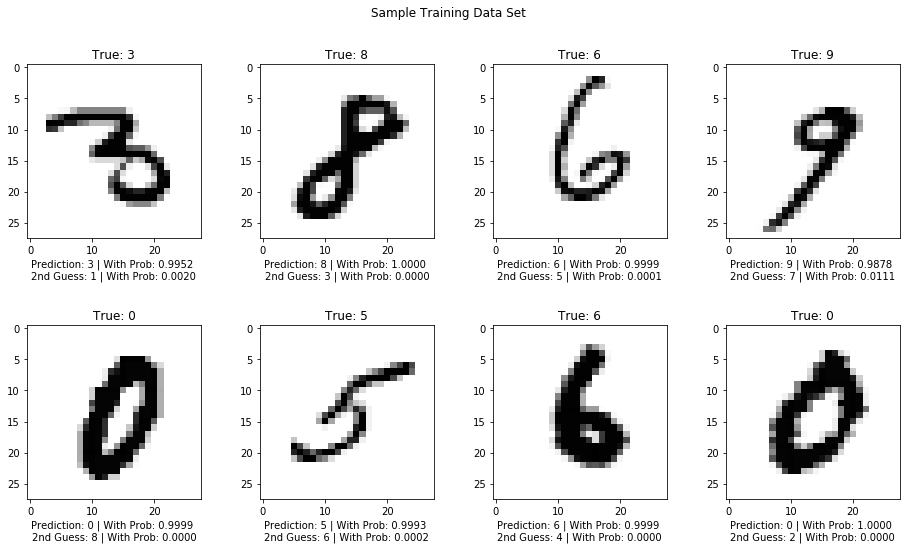

In [293]:
visualize_prediction(train_x_orig, train_y_orig.T, prediction_train, dataset = "training")

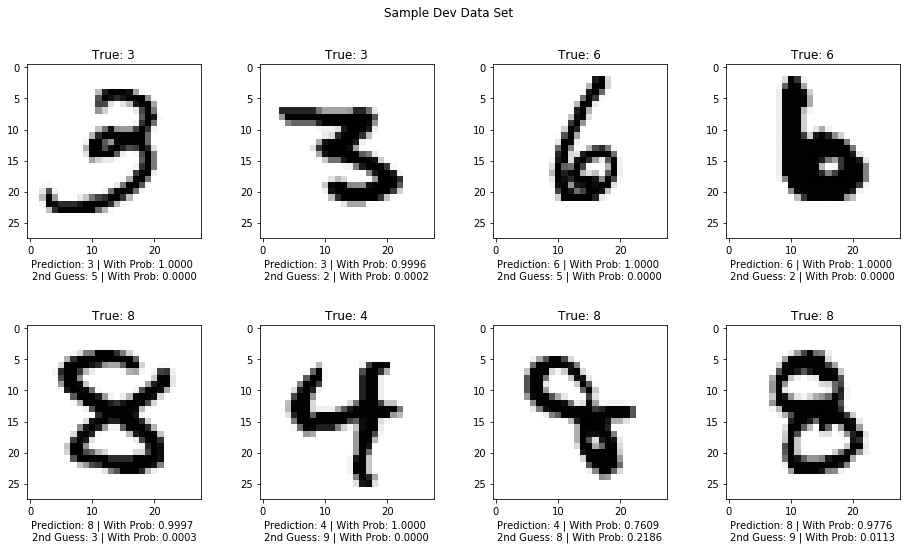

In [294]:
visualize_prediction(dev_x_orig, dev_y_orig.T, prediction_dev, dataset = "dev")

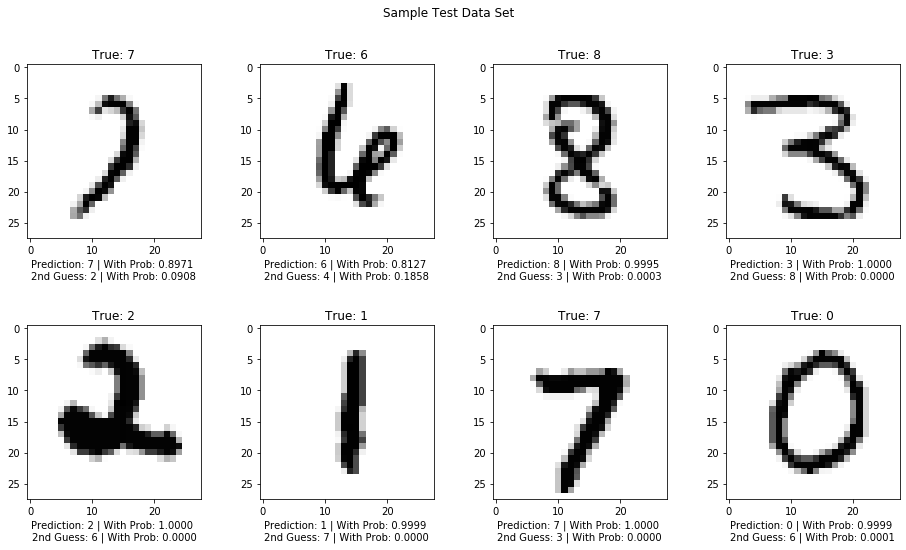

In [296]:
visualize_prediction(test_x_orig, test_y_orig.T, prediction_test,dataset = "test")

#### Visualizing Mislabelled Images in all datasets

In [299]:
def visualize_mislabelled_images(x_orig,y_orig,prediction,dataset):
    
    first_lbl, first_prob = prediction["First Prediction"]
    sec_lbl, sec_prob = prediction["Second Prediction"]
    
    true_prediction = np.equal(first_lbl,y_orig)
    mislabelled_indices = np.asarray(np.where(true_prediction == False))
    print("Total Mislabelled Images: "+str(len(mislabelled_indices[0])))
    
    if(dataset == "training"):
        visual_title = "Sample Mislabelled Training Images"
    elif(dataset == "dev"):
        visual_title = "Sample Mislabelled Dev Images"
    elif(dataset == "test"):
        visual_title = "Sample Mislabelled Test Images"
    else:
        raise ValueError("Dataset set must be training or dev or test set")
    
    fig, axes = plt.subplots(nrows=2, ncols=5,figsize=(16,8))
    fig.subplots_adjust(hspace=1)
    fig.suptitle(visual_title)

    
    
    for ax,i in zip(axes.flatten(),mislabelled_indices[1]):
        ax.imshow(x_orig[i].squeeze(),interpolation='nearest')
        ax.set(title = "True: "+ str(y_orig[0,i]))
        ax.set(xlabel= "Prediction: %d | With Prob: %.4f \n2nd Guess: %d | With Prob: %.4f"%(first_lbl[0,i], first_prob[0,i], sec_lbl[0,i], sec_prob[0,i]))
    

Total Mislabelled Images: 252


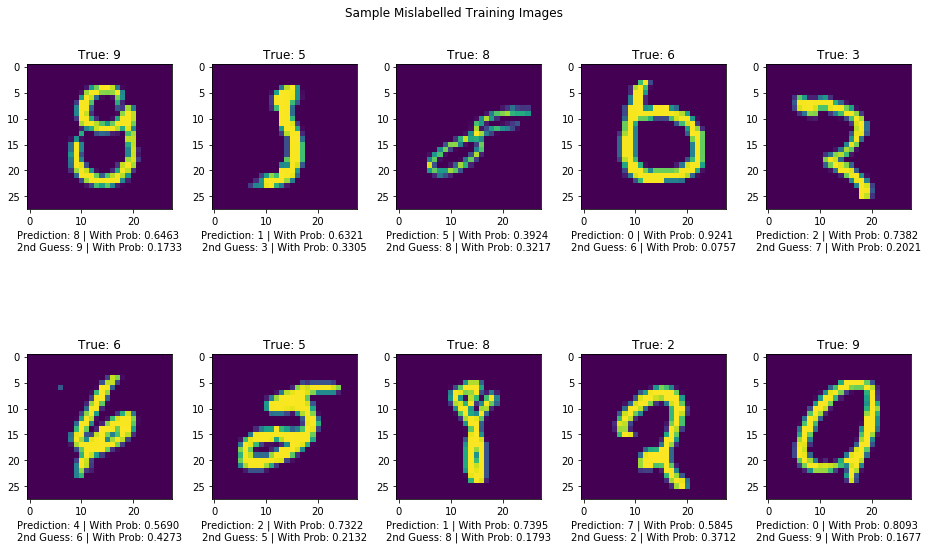

In [300]:
visualize_mislabelled_images(train_x_orig, train_y_orig.T,prediction_train,dataset = "training")

Total Mislabelled Images: 103


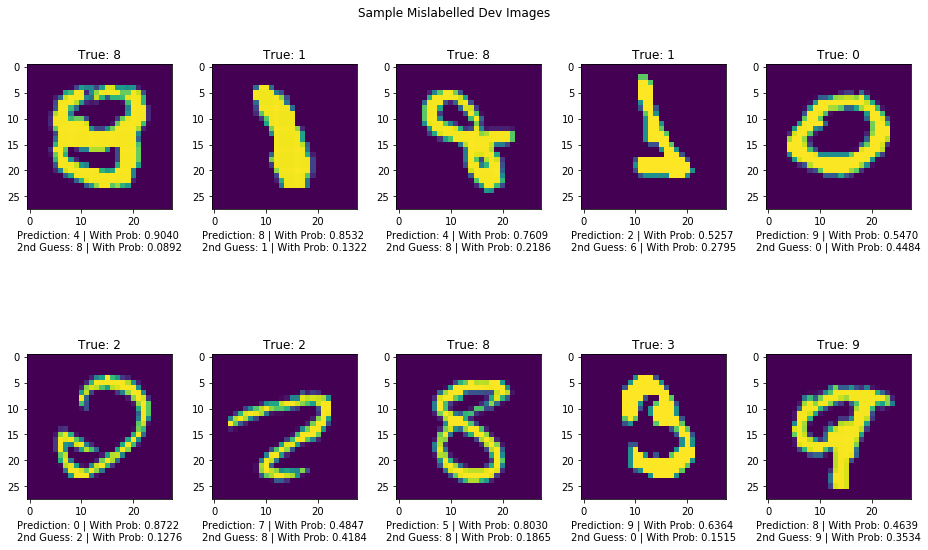

In [301]:
visualize_mislabelled_images(dev_x_orig, dev_y_orig.T, prediction_dev,dataset = "dev")

Total Mislabelled Images: 95


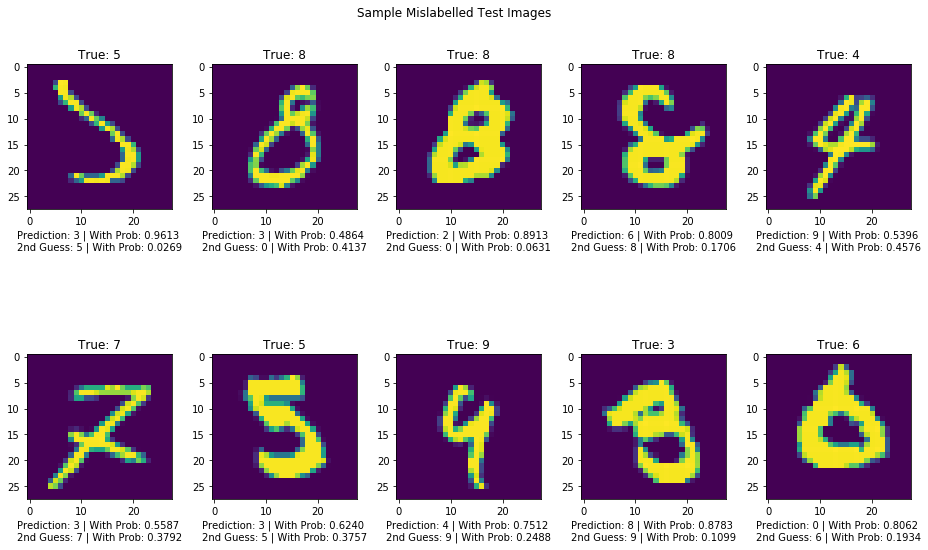

In [302]:
visualize_mislabelled_images(test_x_orig, test_y_orig.T, prediction_test,dataset = "test")

### Predicting Real Time images

In [303]:
from PIL import Image
from dataPrep import one_hot_encoding

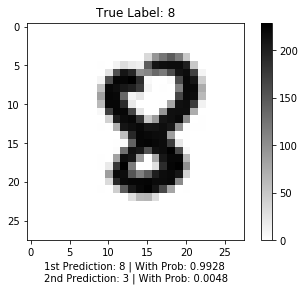

In [304]:
image_name = "8_1.jpg" 
label = np.array([8]).reshape(1,1)

fname = "dataset/" + image_name

image_data =255 - np.asarray(Image.open(fname).convert('L').resize((28,28)))
image_flattened = image_data.reshape(image_data.shape[0]*image_data.shape[1],-1)
image_norm =(image_flattened/255.)

label_encoded = one_hot_encoding(label)

prediction,acc,_ = predict(image_norm, label_encoded, parameters)


first_lbl, first_prob = prediction["First Prediction"]
sec_lbl, sec_prob = prediction["Second Prediction"]

plt.title("True Label: "+ str(label.squeeze()))
plt.xlabel("1st Prediction: %d | With Prob: %.4f \n2nd Prediction: %d | With Prob: %.4f"%(first_lbl, first_prob, sec_lbl, sec_prob))
plt.imshow(image_data, interpolation ='nearest',cmap='binary')
plt.colorbar()


In [53]:
import pickle

def save_model(file_name, parameters):
    
        with open(file_name ,'wb') as output_file:
            pickle.dump(parameters,output_file)

In [54]:
save_model(file_name = "final_model_adam_dropout", parameters = parameters)

In [55]:
def load_model(file_name):
    try: 
        with open(file_name ,'rb') as input_file:
            parameters = pickle.load(input_file)
        
        return parameters
    
    except(OSError, IOError) as e:
        print(e)

In [56]:
loaded_params = load_model(file_name = "final_model_adam_dropout")
print(type(loaded_params), type(parameters))

<class 'dict'> <class 'dict'>


In [57]:
L = len(loaded_params) // 2
print("Total Layers %d: "%L)

for l in range(L):
    print(loaded_params["W" + str(l+1)].shape[0])


Total Layers 3: 
800
300
10
